In [1]:
import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

DIR = '../data/'

def load_data(file_name, head = 30000):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)
            
            # break if reaches the total 'head' line
            if (head is not None) and (count > head):
                break
    return data


books = load_data(os.path.join(DIR, 'goodreads_books.json.gz'),None)
reviews = load_data(os.path.join(DIR, 'goodreads_reviews_dedup.json.gz'))

print(' == sample record (books) ==')
display(np.random.choice(books))
print(' == sample record (authors) ==')
display(np.random.choice(reviews))



 == sample record (books) ==


{'isbn': '0805059784',
 'text_reviews_count': '8',
 'series': [],
 'country_code': 'US',
 'language_code': '',
 'popular_shelves': [{'count': '120', 'name': 'to-read'},
  {'count': '6', 'name': 'default'},
  {'count': '5', 'name': 'film'},
  {'count': '2', 'name': 'favorites'},
  {'count': '2', 'name': 'screenplays'},
  {'count': '2', 'name': 'plays'},
  {'count': '2', 'name': 'owned'},
  {'count': '2', 'name': 'american'},
  {'count': '2', 'name': 'screenplay'},
  {'count': '2', 'name': 'fiction'},
  {'count': '1', 'name': 'non'},
  {'count': '1', 'name': 'added-2017'},
  {'count': '1', 'name': 'stanza-b'},
  {'count': '1', 'name': 'on-my-own'},
  {'count': '1', 'name': 'next-to-read'},
  {'count': '1', 'name': 'alınacaklar'},
  {'count': '1', 'name': 'mine'},
  {'count': '1', 'name': 'senaryo'},
  {'count': '1', 'name': 'to-buy'},
  {'count': '1', 'name': 'lost-books'},
  {'count': '1', 'name': 'auster'},
  {'count': '1', 'name': 'de'},
  {'count': '1', 'name': 'to-read-pile'},
  {'c

 == sample record (authors) ==


{'user_id': 'b54c83f02c748fe75ed309e1e12eace2',
 'book_id': '10416034',
 'review_id': 'c953f406bcc1a5320891cf6fa6ed03bb',
 'rating': 4,
 'review_text': "m ldhy yj`l lrwy@ jyd@ ? ktb mshhwr ? dr nshr kbyr@ ? `lm wbhrj@ ? ... m yj`lny 'sh`r b'nny qr't rwy@ jyd@ wnHn ntHdth hn `n lrwy@ l lktb b`mwmyth .. hw 'nk l tryd 'n ttrk lrwy@ Ht~ t`rf m ldhy Hdth .. 'n ykwn `nSr ltshwyq wlGrb@ mwjwdan yj`l lrwy@ jyd@ jdan .. whkdh hy hdhh lrwy@ .. rbm kn ymkn tSnyfh fy 'db lkhyl l`lmy .. wlknh mshwq@ blf`l .. lG@ bsyT@ wsrdy@ w'fkr mtrbT@ .. knt l'twq` lh mstqbl synmy'yan lwl 'nh tSnf krwy@ (m`dy@ llsmy@) bshkl qwy :) '`tqd bnh ln tkwn akhr m 'qr'h llktb lmbd`",
 'date_added': 'Fri Dec 06 19:58:35 -0800 2013',
 'date_updated': 'Tue Dec 10 23:48:06 -0800 2013',
 'read_at': '',
 'started_at': '',
 'n_votes': 9,
 'n_comments': 0}

In [2]:
df_reviews = pd.DataFrame(reviews)

df_reviews.head(5)

df_books = pd.DataFrame(books)


In [3]:
# encode for user_ids
user_ids = df_reviews["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

#print(userencoded2user)

# encode for book
book_ids = df_reviews["book_id"].unique().tolist()
# book_ids = df_books["book_id"].unique().tolist()
book2book_encoded = {x: i for i, x in enumerate(book_ids)}
book_encoded2book = {i: x for i, x in enumerate(book_ids)}

#print(book2book_encoded)



In [8]:
#user2user_encoded

In [9]:
#book2book_encoded

In [4]:

df_reviews["user"] = df_reviews["user_id"].map(user2user_encoded)
df_reviews["book"] = df_reviews["book_id"].map(book2book_encoded)

num_users = len(user2user_encoded)
num_books = len(book_encoded2book)
df_reviews["rating"] = df_reviews["rating"].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = min(df_reviews["rating"])
max_rating = max(df_reviews["rating"])

print(
    "Number of users: {}, Number of Books: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_books, min_rating, max_rating
    )
)

Number of users: 606, Number of Books: 23825, Min rating: 0.0, Max rating: 5.0


In [5]:
df_reviews = df_reviews.sample(frac=1, random_state=42)
x = df_reviews[["user", "book"]].values

# Normalize the targets between 0 and 1. Makes it easy to train.
y = df_reviews["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.7 * df_reviews.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)



In [6]:
display(x)
display(y)
display(df_reviews.shape)
display(df_reviews.shape[0])
display(train_indices)

array([[   30,  2260],
       [  449,   316],
       [  601,  2950],
       ...,
       [   13,   858],
       [  344, 13457],
       [  465,  1100]], dtype=int64)

array([0.6, 1. , 1. , ..., 0.8, 0.8, 0.8])

(30001, 13)

30001

21000

In [7]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_books, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_books = num_books
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.book_embedding = layers.Embedding(
            num_books,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.book_bias = layers.Embedding(num_books, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        book_vector = self.book_embedding(inputs[:, 1])
        book_bias = self.book_bias(inputs[:, 1])
        dot_user_book = tf.tensordot(user_vector, book_vector, 2)
        # Add all the components (including bias)
        x = dot_user_book + user_bias + book_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_books, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

C:\Users\tuck_wai_foong\AppData\Local\Continuum\anaconda3\envs\python-djproject_new\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=6,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/6
329/329 [==============================] - 7s 14ms/step - loss: 0.6728 - val_loss: 0.6519
Epoch 2/6
329/329 [==============================] - 4s 13ms/step - loss: 0.5659 - val_loss: 0.6534
Epoch 3/6
329/329 [==============================] - 5s 14ms/step - loss: 0.5562 - val_loss: 0.6521
Epoch 4/6
329/329 [==============================] - 5s 16ms/step - loss: 0.5507 - val_loss: 0.6511
Epoch 5/6
329/329 [==============================] - 5s 16ms/step - loss: 0.5462 - val_loss: 0.6505
Epoch 6/6
329/329 [==============================] - 6s 17ms/step - loss: 0.5422 - val_loss: 0.6500


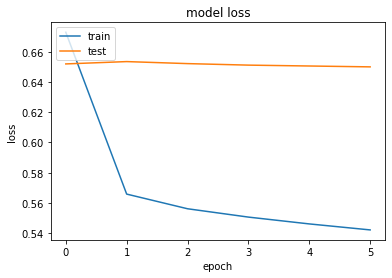

In [9]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [10]:
display(df_reviews.user_id.sample(1).iloc[0])
display(df_reviews.head())
display(df_reviews.user_id)


'7ac68d284be15768081bd3e86a1431c9'

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,user,book
2308,d37b46b2190ed7c518259f29b47a9b36,28587592,f09c6dd30c575ff662c2473ed94898ba,3.0,Welcome to the strange new world of girls and ...,Thu Feb 18 18:58:19 -0800 2016,Wed Apr 06 07:34:51 -0700 2016,Wed Apr 06 07:37:13 -0700 2016,Mon Mar 21 00:00:00 -0700 2016,2,2,30,2260
22405,f3b6681e5b08aa06cfff4db8833284a9,15507958,c63fffbc23c2674adf728e53c312d482,5.0,Read it with a box of tissues!!!,Sat Oct 12 11:51:02 -0700 2013,Tue Jul 07 09:10:12 -0700 2015,Fri Oct 18 08:36:34 -0700 2013,Sat Oct 12 00:00:00 -0700 2013,0,0,449,316
29877,9886b578a7f06870ebe570f58f2aa370,5485,b40d35d46604e3e6f3aac8f744ecb9c0,5.0,A fascinating commentary before its time. Rema...,Thu Feb 21 17:04:57 -0800 2013,Sun Mar 26 09:53:50 -0700 2017,,,0,0,601,2950
25059,f8d60b7b9ab89a0829766aaadce70d01,12416502,0d72016a79a4a445666678e19d242bed,5.0,DWED Reviews Talee and the Fallen Object \n Ra...,Fri Mar 08 16:56:53 -0800 2013,Fri Mar 08 16:57:56 -0800 2013,Thu Feb 28 00:00:00 -0800 2013,,1,0,495,20319
2664,2f6af21d14c83a5df6cdcef5e6af0b3e,17572903,7b3bd4c777160087515c1f1bb77462de,3.0,This book has highs and lows--stars are the av...,Fri Jan 24 08:06:23 -0800 2014,Sun Jan 26 15:25:35 -0800 2014,Sat Jan 25 00:00:00 -0800 2014,Fri Jan 24 00:00:00 -0800 2014,0,0,42,2582


2308     d37b46b2190ed7c518259f29b47a9b36
22405    f3b6681e5b08aa06cfff4db8833284a9
29877    9886b578a7f06870ebe570f58f2aa370
25059    f8d60b7b9ab89a0829766aaadce70d01
2664     2f6af21d14c83a5df6cdcef5e6af0b3e
                       ...               
29802    ab2fadb5c7bbe55c80406d2b3692e969
5390     617ccec66dac2d1029600ed3d706e8ed
860      01ec1a320ffded6b2dd47833f2c8e4fb
15795    f1be68e7aec2297644ee1fefe40b933d
23654    68f9915717ccc347b5f46f1b11ec40fe
Name: user_id, Length: 30001, dtype: object

In [74]:
# NOW , check ALL available BOOKs from BOOK dataset

#df_books = pd.DataFrame(books)

# display(df_books.head(5))



,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
0,0312853122,1,[],US,,"[{'count': '3', 'name': 'to-read'}, {'count': ...",,false,4.00,,...,9,,1984,https://www.goodreads.com/book/show/5333265-w-...,https://images.gr-assets.com/books/1310220028m...,5333265,3,5400751,W.C. Fields: A Life on Film,W.C. Fields: A Life on Film
1,0743509986,6,[],US,,"[{'count': '2634', 'name': 'to-read'}, {'count...",,false,3.23,B000FC0PBC,...,10,Abridged,2001,https://www.goodreads.com/book/show/1333909.Go...,https://s.gr-assets.com/assets/nophoto/book/11...,1333909,10,1323437,Good Harbor,Good Harbor
2,,7,[189911],US,eng,"[{'count': '58', 'name': 'to-read'}, {'count':...",B00071IKUY,false,4.03,,...,,Book Club Edition,1987,https://www.goodreads.com/book/show/7327624-th...,https://images.gr-assets.com/books/1304100136m...,7327624,140,8948723,"The Unschooled Wizard (Sun Wolf and Starhawk, ...","The Unschooled Wizard (Sun Wolf and Starhawk, ..."
3,0743294297,3282,[],US,eng,"[{'count': '7615', 'name': 'to-read'}, {'count...",,false,3.49,B002ENBLOK,...,7,,2009,https://www.goodreads.com/book/show/6066819-be...,https://s.gr-assets.com/assets/nophoto/book/11...,6066819,51184,6243154,Best Friends Forever,Best Friends Forever
4,0850308712,5,[],US,,"[{'count': '32', 'name': 'to-read'}, {'count':...",,false,3.40,,...,,,,https://www.goodreads.com/book/show/287140.Run...,https://images.gr-assets.com/books/1413219371m...,287140,15,278577,Runic Astrology: Starcraft and Timekeeping in ...,Runic Astrology: Starcraft and Timekeeping in ...


In [45]:
book2book_encoded.keys()

dict_keys(['24375664', '18245960', '6392944', '22078596', '6644782', '1995421', '9460786', '29983426', '29893493', '28114110', '16981', '8191070', '28684704', '27161156', '32768285', '32283133', '16064871', '28119237', '30282601', '20873740', '25884323', '19398490', '23310161', '18662473', '10405048', '22875447', '4866', '23158207', '22318578', '24189224', '22551730', '22816087', '9151181', '17290220', '6954929', '18176747', '5577844', '21792828', '19816540', '17855756', '16158596', '12961964', '8125726', '17315048', '17860739', '137554', '210009', '5064', '19404862', '8545079', '460548', '18659415', '123715', '17451257', '13526165', '8622058', '16033093', '10294362', '6486483', '3977', '13453029', '11869272', '40955', '16008171', '12953520', '13239822', '9850443', '7315573', '12969594', '5572634', '8296156', '8664353', '7632329', '12727969', '11297044', '9418327', '12567957', '4986701', '62291', '10552338', '6563914', '9938498', '831635', '11474551', '18914012', '478', '10139649', '85

In [12]:
user_id = df_reviews.user_id.sample(1).iloc[0]

#user_id = 'fe0df2eff573e75c036eb8287c6b012a'

books_read_by_user = df_reviews[df_reviews.user_id == user_id]

books_not_read = df_books[
    ~df_books["book_id"].isin(books_read_by_user.book_id.values)
]["book_id"]

print('1==',user_id)
print('2==',books_read_by_user)
print('3==',books_not_read.head(100))

books_not_read = list(
    set(str(books_not_read)).intersection(set(book2book_encoded.keys()))
)

print('4==',books_not_read)

books_not_read = [[book2book_encoded.get(x)] for x in books_not_read]
user_encoder = user2user_encoded.get(user_id)

print('5==',user_encoder)

user_book_array = np.hstack(
    ([[user_encoder]] * len(books_not_read), books_not_read)
)

print('6==',user_book_array)

ratings = model.predict(user_book_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]

print('7==',ratings)
print(top_ratings_indices)


1== 5cca1dd30cd5a98c1c8e731839265ccf
2==                                user_id   book_id  \
8832  5cca1dd30cd5a98c1c8e731839265ccf  13049981   
8892  5cca1dd30cd5a98c1c8e731839265ccf  10280563   
9153  5cca1dd30cd5a98c1c8e731839265ccf   6644117   
9144  5cca1dd30cd5a98c1c8e731839265ccf   6482837   
8834  5cca1dd30cd5a98c1c8e731839265ccf  16248148   
...                                ...       ...   
8924  5cca1dd30cd5a98c1c8e731839265ccf   8994333   
9007  5cca1dd30cd5a98c1c8e731839265ccf   6505358   
9151  5cca1dd30cd5a98c1c8e731839265ccf   6522388   
9146  5cca1dd30cd5a98c1c8e731839265ccf   3657138   
8838  5cca1dd30cd5a98c1c8e731839265ccf  13326677   

                             review_id  rating  \
8832  9c6caa6fc47dadcd08d97660ed9ed13b     5.0   
8892  12847487d42cede4a5fcf80c8bab5c04     0.0   
9153  6717805d1b4c30c4cf4b9bb4e7f2e200     4.0   
9144  9248ae54155ad4cef2f9ec51369ba79d     5.0   
8834  8284319285c598deadd89664e2902dbe     0.0   
...                               

In [81]:
book_encoded2book

{0: '1283394',
 1: '23309843',
 2: '13343752',
 3: '28818921',
 4: '19167601',
 5: '354501',
 6: '15945853',
 7: '30187',
 8: '6411961',
 9: '18705209',
 10: '26248016',
 11: '170210',
 12: '15704207',
 13: '9842979',
 14: '16281177',
 15: '24146429',
 16: '7005509',
 17: '693208',
 18: '6124878',
 19: '11559200',
 20: '23507478',
 21: '965128',
 22: '20821149',
 23: '11051889',
 24: '5463765',
 25: '551876',
 26: '60510',
 27: '16169349',
 28: '17061488',
 29: '17825218',
 30: '7445',
 31: '30301478',
 32: '18731511',
 33: '13206828',
 34: '6559316',
 35: '30056689',
 36: '8419552',
 37: '1428',
 38: '8176166',
 39: '22822858',
 40: '29430788',
 41: '4505161',
 42: '22336924',
 43: '25735032',
 44: '15704307',
 45: '3446',
 46: '34879265',
 47: '17245',
 48: '1244577',
 49: '54072',
 50: '25205326',
 51: '1843',
 52: '23297300',
 53: '262430',
 54: '26247008',
 55: '6911529',
 56: '19504931',
 57: '6561975',
 58: '12983100',
 59: '17983690',
 60: '13151360',
 61: '6931356',
 62: '2820

In [13]:
books_not_read

[[286], [2383], [2879], [2878], [285]]

In [16]:
#books = load_data(os.path.join(DIR, 'goodreads_books.json.gz'),None) # load all books data

recommended_book_ids = [
    book_encoded2book.get(books_not_read[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_books_user = (
    books_read_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .book_id.values
)
book_df_rows = df_books[df_books["book_id"].isin(top_books_user)]
for row in book_df_rows.itertuples():
    print(row.title)

print("----" * 8)
print("Top 10 Book recommendations")
print("----" * 8)
recommended_books = df_books[df_books["book_id"].isin(recommended_book_ids)]
for row in recommended_books.itertuples():
    print(row.title)

Showing recommendations for user: 5cca1dd30cd5a98c1c8e731839265ccf
Movies with high ratings from user
--------------------------------
Code Name Verity (Code Name Verity, #1)
Between Here and Forever
Matched (Matched, #1)
Liesl & Po
Boundless (Unearthly, #3)
--------------------------------
Top 10 Book recommendations
--------------------------------
Harry Potter and the Half-Blood Prince (Harry Potter, #6)
Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)
Harry Potter and the Sorcerer's Stone (Harry Potter, #1)
Harry Potter and the Order of the Phoenix (Harry Potter, #5)
Harry Potter and the Goblet of Fire (Harry Potter, #4)


### ONLY CAN show Top 5 Books for Recommedations as we only load 30000 rows data from Book (goodreads_books.json.gz)

Top 10 Book recommendations showing no data because not all 